In [30]:
import numpy as np
import random
import time
import pyaudio
import struct
import sys
import io
import os
from os import path
import glob
import IPython
import matplotlib.pyplot as plt
import soundfile as sf
import wave

In [38]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 1.01

p = pyaudio.PyAudio()

inputs = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

In [3]:
IPython.display.Audio("./Act_train/activation/2.wav")

In [4]:
IPython.display.Audio("./Act_train/negative/50.wav")

In [5]:
act = []
for i in range(15):
    act.append("./Act_train/activation/"+str(i+1)+".wav")

In [6]:
neg = []
for i in range(120):
    neg.append("./Act_train/negative/"+str(i+1)+".wav")

In [7]:
act, neg = np.array(act), np.array(neg)
print(act.shape)
print(neg.shape)

(15,)
(120,)


In [8]:
Tx = 548 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [9]:
def get_wav_info(wav_file):
    data, rate = sf.read(wav_file)
    return data, rate

def graph_spectrogram(wav_file):
    data, rate = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = Tx # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

In [10]:
def create_training_example(activates, negatives):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    Ty -- The number of time steps in the output

    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """

    y = 0
    x = None
    flag = np.random.randint(1, 121)
    if flag%5==0:
        x = graph_spectrogram(activates[np.random.choice(len(activates))])
        y = 1
    else:
        x = graph_spectrogram(negatives[np.random.choice(len(negatives))])
    
    return x, y

In [11]:
#print(len(act[0]))
#graph_spectrogram(act[0])

<class 'numpy.ndarray'>
0
(548, 101)


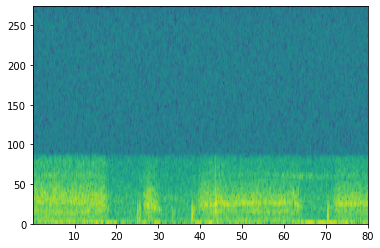

In [13]:
x, y = create_training_example(act, neg)
print(type(x))
print((y))
print(x.swapaxes(0,1).shape)

In [14]:
nsamples = 1000
ntimes=5

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


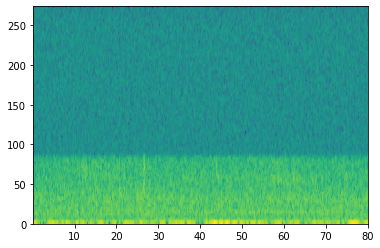

In [15]:
for j in range(ntimes):
    X = []
    Y = []
    for i in range(0, nsamples):
        if i%100 == 0:
            print(i)
        x, y = create_training_example(act, neg)
        X.append(x.swapaxes(0,1))
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y).reshape((nsamples, 1))
    # Save the data for further uses
    np.save(f'./Act_train/XY_train/X'+str(j+1)+'.npy', X)
    np.save(f'./Act_train/XY_train/Y'+str(j+1)+'.npy', Y)

In [16]:
print(X.shape)
print(Y.shape)
print("True" if 1 in Y else "False")

(1000, 548, 101)
(1000, 1)
True


0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


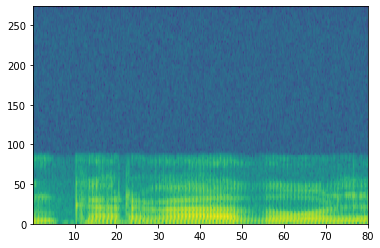

In [17]:
X = []
Y = []
for j in range(ntimes):
    X_dev = []
    Y_dev = []
    for i in range(0, nsamples):
        if i%100 == 0:
            print(i)
        x, y = create_training_example(act, neg)
        X_dev.append(x.swapaxes(0,1))
        Y_dev.append(y)
    X_dev = np.array(X_dev)
    Y_dev = np.array(Y_dev).reshape((nsamples, 1))
    np.save(f'./Act_train/XY_dev/X_dev'+str(j+1)+'.npy', X_dev)
    np.save(f'./Act_train/XY_dev/Y_dev'+str(j+1)+'.npy', Y_dev)

In [18]:
X_dev = []
Y_dev = []

In [ ]:
X_dev = np.load("./Act_train/XY_dev/X_dev.npy")
Y_dev = np.load("./Act_train/XY_dev/Y_dev.npy")

In [19]:
print((Y_dev[0]))
print(type(Y_dev))
print(Y_dev.shape)
print(X_dev.shape)


IndexError: list index out of range

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
model = load_model("modelo")

In [21]:
def modelf(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    X = Conv1D(filters = 196, kernel_size=15, strides=4)(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Dropout(rate=0.8)(X)                                  

    X = GRU(units = 128, return_sequences=True)(X)
    X = Dropout(rate = 0.8)(X)
    X = BatchNormalization()(X)                           
    
    X = GRU(units = 128, return_sequences=True)(X)
    X = Dropout(rate = 0.8)(X)       
    X = BatchNormalization()(X) 

    X = GRU(units = 60, return_sequences=True)(X)
    X = Dropout(rate = 0.8)(X)       
    X = BatchNormalization()(X)
    
    X = GRU(units = 60, return_sequences=True)(X)
    X = Dropout(rate = 0.8)(X)       
    X = BatchNormalization()(X) 
    
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) 
    X = Dense(1, activation = "sigmoid")(Flatten()(X))

    model = Model(inputs = X_input, outputs = X)
    
    return model

In [22]:
model = modelf(input_shape = (Tx, n_freq))

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 548, 101)]        0         
                                                                 
 conv1d (Conv1D)             (None, 134, 196)          297136    
                                                                 
 batch_normalization (BatchN  (None, 134, 196)         784       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 134, 196)          0         
                                                                 
 dropout (Dropout)           (None, 134, 196)          0         
                                                                 
 gru (GRU)                   (None, 134, 128)          125184    
                                                             

In [24]:
opt = Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [27]:
for j in range(5):
    print(str(j+1))
    X = np.load("./Act_train/XY_train/X"+str(j+1)+".npy")
    Y = np.load("./Act_train/XY_train/Y"+str(j+1)+".npy")
    model.fit(X, Y, batch_size = 5, epochs=20)

1
Epoch 1/20
200/200 [==============================] - 24s 117ms/step - loss: 0.5613 - accuracy: 0.7810
Epoch 2/20
200/200 [==============================] - 25s 126ms/step - loss: 0.5651 - accuracy: 0.7900
Epoch 3/20
200/200 [==============================] - 25s 123ms/step - loss: 0.5620 - accuracy: 0.7860
Epoch 4/20
200/200 [==============================] - 24s 119ms/step - loss: 0.5561 - accuracy: 0.7930
Epoch 5/20
200/200 [==============================] - 23s 116ms/step - loss: 0.5513 - accuracy: 0.8000
Epoch 6/20
200/200 [==============================] - 23s 117ms/step - loss: 0.5644 - accuracy: 0.7940
Epoch 7/20
200/200 [==============================] - 23s 117ms/step - loss: 0.5497 - accuracy: 0.7950
Epoch 8/20
200/200 [==============================] - 23s 117ms/step - loss: 0.5537 - accuracy: 0.7930
Epoch 9/20
200/200 [==============================] - 23s 116ms/step - loss: 0.5567 - accuracy: 0.7920
Epoch 10/20
200/200 [==============================] - 23s 116ms/step -

200/200 [==============================] - 24s 121ms/step - loss: 0.5265 - accuracy: 0.7960
5
Epoch 1/20
200/200 [==============================] - 25s 127ms/step - loss: 0.5226 - accuracy: 0.7870
Epoch 2/20
200/200 [==============================] - 25s 124ms/step - loss: 0.5267 - accuracy: 0.7890
Epoch 3/20
200/200 [==============================] - 24s 122ms/step - loss: 0.5347 - accuracy: 0.7880
Epoch 4/20
200/200 [==============================] - 25s 123ms/step - loss: 0.5335 - accuracy: 0.7880
Epoch 5/20
200/200 [==============================] - 25s 123ms/step - loss: 0.5327 - accuracy: 0.7880
Epoch 6/20
200/200 [==============================] - 24s 122ms/step - loss: 0.5298 - accuracy: 0.7880
Epoch 7/20
200/200 [==============================] - 25s 124ms/step - loss: 0.5235 - accuracy: 0.7880
Epoch 8/20
200/200 [==============================] - 25s 123ms/step - loss: 0.5251 - accuracy: 0.7860
Epoch 9/20
200/200 [==============================] - 25s 123ms/step - loss: 0.519

In [28]:
for j in range (5):
    X_dev = np.load("./Act_train/XY_dev/X_dev"+str(j+1)+".npy")
    Y_dev = np.load("./Act_train/XY_dev/Y_dev"+str(j+1)+".npy")
    loss, acc, = model.evaluate(X_dev, Y_dev)
    print("Dev set accuracy = ", acc)

32/32 [==============================] - 4s 69ms/step - loss: 0.4940 - accuracy: 0.8030
Dev set accuracy =  0.8029999732971191
32/32 [==============================] - 2s 69ms/step - loss: 0.5157 - accuracy: 0.7860
Dev set accuracy =  0.7860000133514404
32/32 [==============================] - 2s 68ms/step - loss: 0.4970 - accuracy: 0.8010
Dev set accuracy =  0.8009999990463257
32/32 [==============================] - 2s 68ms/step - loss: 0.5244 - accuracy: 0.7790
Dev set accuracy =  0.7789999842643738
32/32 [==============================] - 2s 68ms/step - loss: 0.4785 - accuracy: 0.8150
Dev set accuracy =  0.8149999976158142


In [29]:
X, Y= [], []

In [ ]:
model.save("modelo")

In [39]:
frames = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = inputs.read(CHUNK)
    frames.append(data)
    wf = wave.open("test.wav", 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()    

(1, 548, 101)

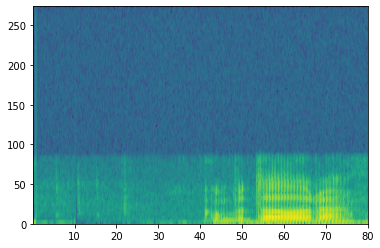

In [42]:
aux = np.array(graph_spectrogram("test.wav").swapaxes(0,1)).reshape((1,548, 101))
aux.shape

In [43]:
predictions = model.predict(aux)

1/1 [==============================] - 1s 1s/step


In [45]:
predictions

array([[0.22265776]], dtype=float32)